In [1]:
from ML_Preparation.Preprocessing_M import DataExtractor, DataPreprocessing

de = DataExtractor("D:/hka-aqm-m", "C:/Users/danie/building_M_data")

df = de.create_df()

No .dat files found in C:/Users/danie/building_M_data. 
 Trying to extract files from the original directory D:/hka-aqm-m
Read data successfully.
Data contains 979166 data points and 18 columns.


In [2]:
label = "CO2"

dp = DataPreprocessing(label = label)

df_preprocessed = dp.preprocess_df(df, rolling_window = "3d", sample_time = "1d")

Number of outliers detected: -73438
Number of normal samples detected: 905728


In [3]:
df_preprocessed.columns

Index(['date_time', 'tmp', 'hum', 'CO2', 'VOC', 'vis', 'IR', 'BLE', 'tavg',
       'tmin', 'tmax', 'wdir', 'wspd', 'wpgt', 'pres', 'room_number',
       'tmp_diff', 'hum_diff', 'VOC_diff', 'vis_diff', 'IR_diff', 'BLE_diff',
       'tavg_diff', 'tmin_diff', 'tmax_diff', 'wdir_diff', 'wspd_diff',
       'wpgt_diff', 'pres_diff', 'year', 'dayofweek', 'hour', 'season',
       'VOC_CO2_ratio'],
      dtype='object')

In [4]:
df_preprocessed.to_parquet("hka_M_preprocessed.parquet")

In [5]:
from ML_Preparation.Feature_Engineering import *

fe = FeatureEngineering(df_preprocessed,
                        label = label, 
                        categorical_features = ["season", "room_number", "dayofweek", "color"],
                        automated_feature_engineering = False)

X_train, y_train, X_test, y_test = fe.feature_engineering(steps_to_forecast = 2, skip_scale = True)

'color'


In [6]:
def transform_data_for_forecasting(data, label_name, n_in, n_out, dropna = True):

    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data[[f"{label_name}"]].shift(-i))
        if i == 0:
            names += [f"{label_name}(t)"]
        else:
            names += [f"{label_name}(t+{i})"]
        # put it all together
        data_reframed = pd.concat(cols, axis=1)
        data_reframed.columns = names
        # drop rows with NaN values
        if dropna:
            data_reframed.dropna(inplace=True)

    return data_reframed

Epoch 1/10


c:\Users\danie\anaconda3\envs\awp1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 - 2s - 30ms/step - loss: 55010.1797
Epoch 2/10
80/80 - 0s - 2ms/step - loss: 37728.3398
Epoch 3/10
80/80 - 0s - 1ms/step - loss: 35710.0898
Epoch 4/10
80/80 - 0s - 1ms/step - loss: 36026.6211
Epoch 5/10
80/80 - 0s - 1ms/step - loss: 34989.9766
Epoch 6/10
80/80 - 0s - 1ms/step - loss: 35639.4648
Epoch 7/10
80/80 - 0s - 1ms/step - loss: 35244.1797
Epoch 8/10
80/80 - 0s - 1ms/step - loss: 34246.7695
Epoch 9/10
80/80 - 0s - 1ms/step - loss: 33860.9023
Epoch 10/10
80/80 - 0s - 2ms/step - loss: 32853.9258


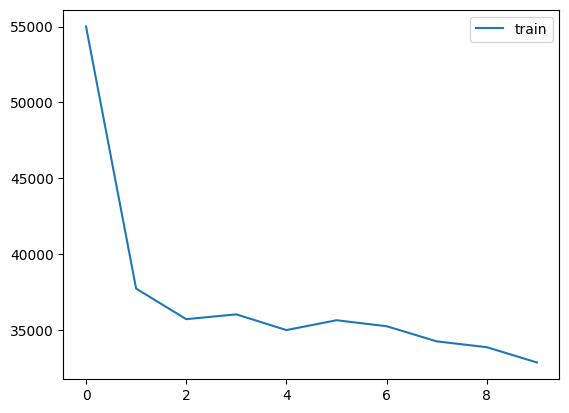

In [10]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout, Bidirectional
from keras.optimizers import Adam, SGD
from matplotlib import pyplot

class MyLSTMModel:
    def __init__(self,
                 n_out, 
                 lstm_units=100,
                 input_shape=(None, fe.X_train.shape[-1]),
                 ):
        self.model = Sequential()
        self.model.add(LSTM(units=lstm_units, input_shape=input_shape, return_sequences = True, recurrent_dropout = 0.3))
        self.model.add(Dropout(0.3))
        self.model.add(Bidirectional(LSTM(units=lstm_units, recurrent_dropout = 0.3)))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(50, activation = "relu"))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(30, activation = "relu"))
        self.model.add(Dropout(0.3))

        self.model.add(Dense(n_out))

        self.model.compile(optimizer=Adam(learning_rate = 0.1), loss='mse')
    
    def summary(self):
        self.model.summary()

# Instantiate the model
my_model = MyLSTMModel(2)

history = my_model.model.fit(fe.X_train, fe.y_train, epochs=10, batch_size=64, 
                             #validation_data=(test_X, test_y), 
                             verbose=2, 
                             #shuffle=False
                             )

pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [11]:
pred = my_model.model.predict(fe.X_test)

pred

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[544.68066, 582.291  ],
       [494.39502, 526.5847 ],
       [452.1007 , 482.74374],
       ...,
       [610.82336, 652.4447 ],
       [438.97656, 468.25204],
       [443.42987, 472.0983 ]], dtype=float32)

In [12]:
fe.y_test

array([[709.8954 , 400.83102],
       [400.83102, 404.0503 ],
       [404.0503 , 429.67374],
       ...,
       [499.87952, 511.16296],
       [511.16296, 493.61   ],
       [493.61   , 479.3641 ]], dtype=float32)

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score
import plotly.express as px
import seaborn as sns


class Evaluator:

    def __init__(self):
        pass

    def evaluate(self, y_pred, y_true):
        print("MSE: ", self.calculate_mse(y_pred = y_pred, y_true = y_true))
        print("RMSE: ", self.calculate_rmse(y_pred = y_pred, y_true = y_true))
        print("MAPE: ", self.calculate_mape(y_pred = y_pred, y_true = y_true))
        print("R2: ", self.calculate_r2(y_pred = y_pred, y_true = y_true))
        print("\n")


    def calculate_mse(self, y_true, y_pred):
        return round(mean_squared_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_rmse(self, y_true, y_pred):
        return round(root_mean_squared_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_mape(self, y_true, y_pred):
        return round(mean_absolute_percentage_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_r2(self, y_true, y_pred):
        return round(r2_score(y_true = y_true, y_pred = y_pred), 2)

ev = Evaluator()

for col in range(0, fe.y_test.shape[1]):
    print(f"t +", col)
    ev.evaluate(y_true = fe.y_test[:, col], y_pred = pred[:, col])

    pred_df = pd.DataFrame(pred[:, col], columns = [f"pred_CO2(t + {col})"])
    pred_df[f"CO2(t + {col})"] = fe.y_test[:, col]

    px.line(y = [fe.y_test[:, col], pred[:, col]], title = f"Prediction for CO2(t + {col})      blue = y_true, red = y_pred").show()


t + 0
MSE:  6336.37
RMSE:  79.6
MAPE:  0.1
R2:  -0.26




t + 1
MSE:  6865.32
RMSE:  82.86
MAPE:  0.12
R2:  -0.38




In [14]:
fe.y_test.shape

(1272, 2)

In [16]:
pred = my_model.model.predict(fe.X_train)

for col in range(0, fe.y_train.shape[1]):
    print(f"t +", col)
    ev.evaluate(y_true = fe.y_train[:, col], y_pred = pred[:, col])

    pred_df = pd.DataFrame(pred[:, col], columns = [f"pred_CO2(t + {col})"])
    pred_df[f"CO2(t + {col})"] = fe.y_train[:, col]

    px.line(y = [fe.y_train[:, col], pred[:, col]], title = f"Prediction for CO2(t + {col})      blue = y_true, red = y_pred").show()

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
t + 0
MSE:  17062.52
RMSE:  130.62
MAPE:  0.15
R2:  0.44




t + 1
MSE:  16904.58
RMSE:  130.02
MAPE:  0.16
R2:  0.45


